# Plot Eurovision winners using python

This file uses the .csv eurovision winners results file produced from the R data analysis and a world shape file to display the winners eurovision has produced spatially. 

The following steps are written below: 

* Import the data.
* Change the column heading.
* Explore the data.
* Join two data.frames together.
* Change nan values to more meaningful values for the plots.
* Plot the data.
* Transform the co-ordinates of the data to a projected format.
* Create a new polygon and clip the world data to this frame.
* Create a plot from this clipped data showing the winning countries and the country labels.

The files required are:

* The world shapefile found in **World_Countries/World_Countries.shp**
* **ebu_winners.csv** file created from the R analysis (found in script.R)

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import adjustText as aT

In [2]:
# import the shapefile and csv file ready for plotting

countries = gpd.read_file('World_Countries/World_Countries.shp')

ebu = pd.read_csv('/data/ebu_winners.csv')

In [3]:
# Check the data int he ebu df and change the win_frequency from float to INT

ebu['win_frequency'] = ebu['win_frequency'].astype(int)

In [4]:
# Change the name of column

countries.rename(columns={'COUNTRY':'country'}, inplace=True)

In [5]:
# Join data frames together 

world_ebu = pd.merge(countries, ebu, left_on='country', right_on='country', how='left')


In [6]:
# Explore data briefly. 

type(world_ebu)

geopandas.geodataframe.GeoDataFrame

In [7]:
# unique values in column "Team"

print(world_ebu['status'].unique())
print(world_ebu['win_frequency'].unique())

[nan 'member' 'associate']
[nan  0.  1.  2.  3.  7.  5.  4.  6.]


In [8]:
# Replace nan value for 'not_a_member' in the status column and nan to 0 for win

# Change from float to int (for win_frequency)

world_ebu['status'].fillna('not a member',inplace=True)
world_ebu['win_frequency'].fillna('0',inplace=True)

In [9]:
# Change from float to int

world_ebu['win_frequency'] = world_ebu['win_frequency'].astype(int)

# Plot two world maps showing the EBU status and the Eurovision winners.

Text(0.5, 1.0, 'EBU Status')

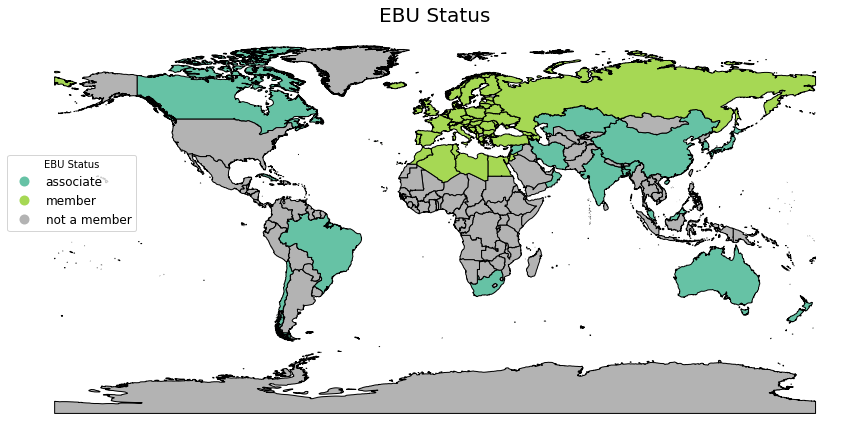

In [10]:
# Plots - EBU status

fig, ax = plt.subplots(figsize=(15, 15))

winners = world_ebu.plot(cmap='Set2', column = 'status', 
               legend=True, edgecolor='black', 
               categorical=True,
               legend_kwds={'bbox_to_anchor':(.15, 0.7),'fontsize':12,
                            'frameon':True, 'title':('EBU Status')}, ax=ax)

winners.axis('off')
winners.set_title('EBU Status',fontsize=20)

Text(0.5, 1.0, 'Eurovision winners')

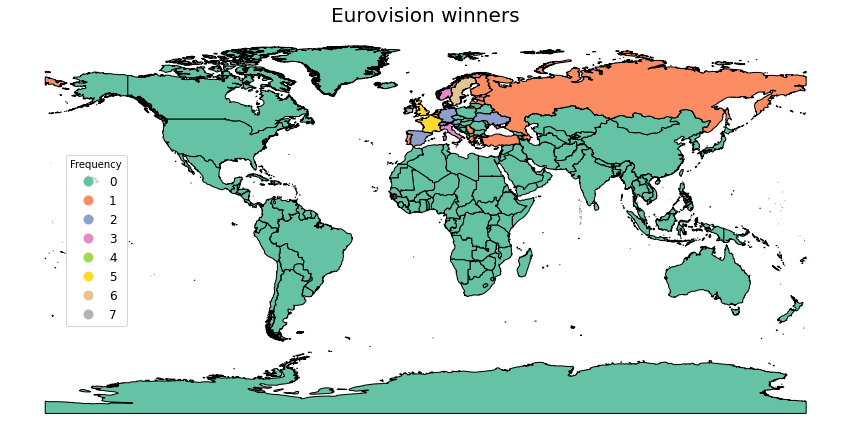

In [11]:
# Plots win frequency 


fig, ax = plt.subplots(figsize=(15, 15))

winners = world_ebu.plot(cmap='Set2', column = 'win_frequency', 
               legend=True, edgecolor='black', 
               categorical=True,
               legend_kwds={'bbox_to_anchor':(.15, 0.7),'fontsize':12,
                            'frameon':True, 'title':('Frequency')}, ax=ax)

winners.axis('off')
winners.set_title('Eurovision winners',fontsize=20)

Whilst these maps show the information it can be seen that it would be better to zoom in on the european area. In this instance it would also be better to project the data. 

## Project the data

In [12]:
#copy the world_ebu into a new data frame. 

data = world_ebu.copy()

In [13]:
# Before changing the projection antartica needs to be removed from the dataset

data = data[(data.country != "Antarctica") & 
            (data.country != "Fr. S. Antarctic Lands")]

In [14]:
# Project the data to the world Mercator projection.

data = data.to_crs(epsg=3395)

In [18]:
%matplotlib inline

(3000000.0, 10000000.0)

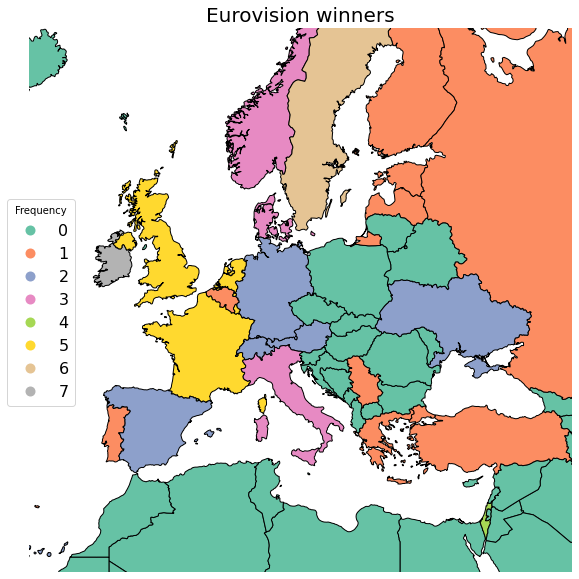

In [19]:
# Plot the data to focus on Europe.

fig, ax = plt.subplots(figsize=(10, 10))

xlim = (-2000000, 5000000)
ylim = (3000000, 10000000)


winners = data.plot(cmap='Set2', column = 'win_frequency', 
               legend=True, edgecolor='black', 
               categorical=True,
               legend_kwds={'bbox_to_anchor':(.1, 0.7),'fontsize':16,
                            'frameon':True, 'title':('Frequency')}, ax=ax)

winners.axis('off')
winners.set_title('Eurovision winners',fontsize=20)
winners.set_xlim(xlim)
winners.set_ylim(ylim)

## Create a new polygon and clip the data

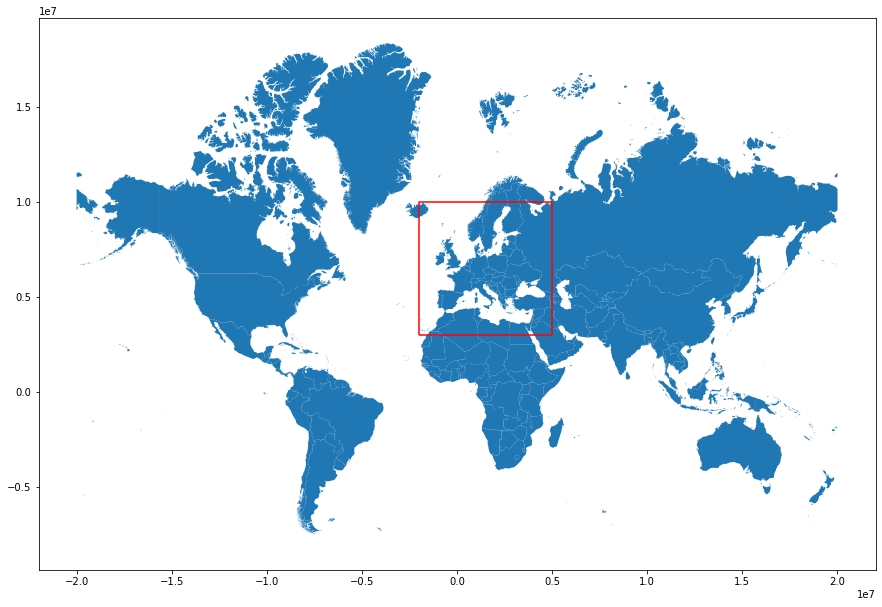

In [21]:
# clip the data frame

import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

# Create a custom polygon
polygon = Polygon([(-2000000, 3000000), (-2000000, 10000000), 
                   (5000000, 10000000), (5000000, 3000000), 
                   (-2000000, 3000000)])


poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=data.crs)

fig, ax = plt.subplots(figsize=(15, 15))
data.plot(ax=ax)
poly_gdf.boundary.plot(ax=ax, color="red");

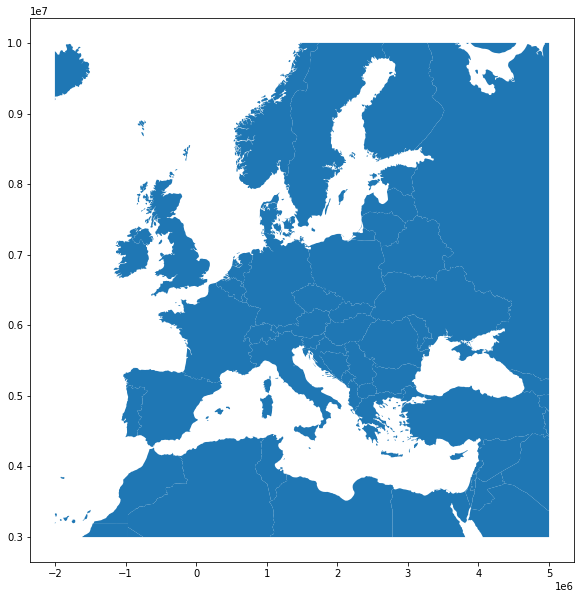

In [24]:
# Clip the data from the polygon using geopandas clip

ebu_clipped = geopandas.clip(data, polygon)

ebu_clipped.plot(figsize=(10,10));

# Add country labels to the map plot.

To plot the names of the countries in the map we need to create a point that sits within each polygon. To do this points need to be created from the polygons from the data.frame and then are added to the plot from the 'country' column in the data.frame. 

In [ ]:
# Change from float to int

ebu_clipped['win_frequency'] = ebu_clipped['win_frequency'].astype(int)

In [27]:
ebu_clipped["rep"] = ebu_clipped["geometry"].representative_point()
ebu_clipped_points = ebu_clipped.copy()
ebu_clipped_points.set_geometry("rep", inplace = True)

1

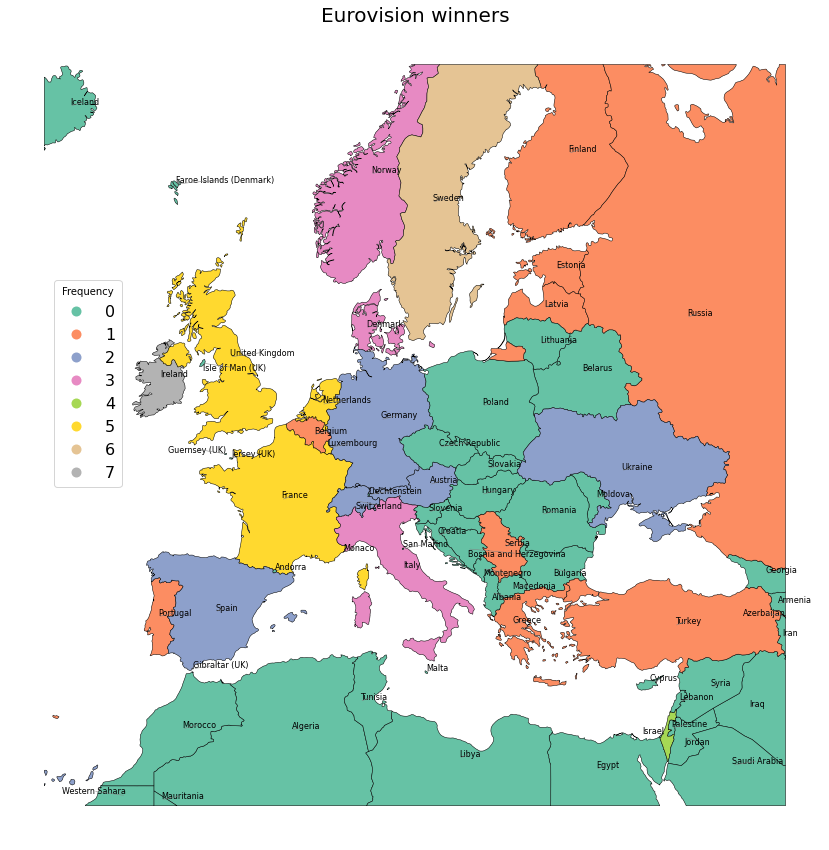

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

winners = ebu_clipped.plot(cmap='Set2', 
                      column = 'win_frequency', edgecolor = "black", 
                      linewidth = 0.5, categorical=True,legend=True,
                      legend_kwds={'bbox_to_anchor':(.15, 0.7),'fontsize':16,
                            'frameon':True, 'title':('Frequency')},ax=ax)
texts = []

winners.axis('off')
winners.set_title('Eurovision winners',fontsize=20)

for x, y, label in zip(ebu_clipped_points.geometry.x, 
                       ebu_clipped_points.geometry.y, 
                       ebu_clipped_points["country"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), 
               expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))